# Clasificador de imágenes de perros y gatos con CNN con Atención Espacial.

In [ ]:
import numpy as np

## Explorando los datos
Se descargan los datos en un fichero zip con 2000 imágenes de perros y gatos. Se descarga el zip y se extraen el directorio /tmp de la máquina virtual local. Estos datos son un subconjunto de
["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-02-19 14:37:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.3MB/s    in 4.2s    

2025-02-19 14:37:46 (15.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Los contenidos del zip son extraídos en el directorio `/tmp/cats_and_dogs_filtered`, conteniendo los directorios `train` and `validation`, los cuales a su vez contienen los subdirectorios `train` and `validation`.

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con las imágenes de entrenamiento de la categoría gato
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con las imágenes de entrenamiento de la categoría perro
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imágenes de validación de la categoría gato
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con las imágenes de validación de la categoría perro
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Visualizando los nombres de las imágenes en los diferentes directorios.

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.658.jpg', 'cat.517.jpg', 'cat.44.jpg', 'cat.536.jpg', 'cat.406.jpg', 'cat.771.jpg', 'cat.634.jpg', 'cat.953.jpg', 'cat.977.jpg', 'cat.45.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Número total de imágenes en cada categoría y directorio.

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Para gatos y perro hay 1000 imágenes en el entrenamiento y 500 en la validación.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parámetros de la imagen, configuración 4x4
nrows = 4
ncols = 4

# Indice sobre las imágenes.
pic_index = 0

Se muestran 8 imágenes de cada tipo.

## Definición de la CNN

Las imágenes color se escalan a tamaño image_size X image_size píxeles, aunque en realidad son objetos 150x150x3 debido a los 3 colores RGB.

In [ ]:
#Se configura el tamaño de las imágenes.
image_size=150

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define un kernel (peso) de forma (1, 1, input_shape[-1], 1)
        # input_shape[-1] será 3 para imágenes RGB
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,1,input_shape[-1],1),
                                      initializer='uniform',
                                      trainable=True)
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        # Aplica una convolución 2D usando el kernel definido
        attention = tf.nn.sigmoid(tf.nn.conv2d(x, self.kernel, strides=[1,1], padding='SAME'))
        # Multiplica la entrada original por la máscara de atención
        return x * attention

In [ ]:
# Capa de entrada de datos: image_size x image_size x 3
img_input = layers.Input(shape=(image_size, image_size, 3))

# Primera capa de atención
SpaAtt = SpatialAttention()(img_input)
print('SpaAtt',SpaAtt.shape)

# Bloque convolucional formado por:
# Capa convolucional con 16 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(16, 3, activation='relu')(SpaAtt)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por:
# Capa convolucional con 32 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por:
# Capa convolucional con 64 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por:
# Capa convolucional con 64 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# En todos las capas anteriores se utiliza la función
# de activación relu.

# A continuación se añaden dos capas densas,
# la primera de las cuales tiene una función de activación relu.
# Finalmente la capa de salida tiene una sola neurona para producir
# un único escalar con función de activación sigmoide para producir
# una salida en el rango entre 0 y 1.

# Se aplana el objeto de forma que en vez se tener un tensor 3D sea 1D.
x = layers.Flatten()(x)

# Capa densa con función de activación relu.
x = layers.Dense(128, activation='relu')(x)

# Capa densa con función de activación relu.
x = layers.Dense(32, activation='relu')(x)

# Capa de salida de una única neurona y función de activación sigmoide.
output = layers.Dense(1, activation='sigmoid')(x)

SpaAtt (None, 150, 150, 3)


In [ ]:
# Crear el modelo:
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention (SpatialAttention) │ (None, 150, 150, 3)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 904,548 (3.45 MB)

 Trainable params: 904,548 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo.
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
batchsize=64
nepochs = 50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes se reescalan en 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# El flujo de imágenes de entrenamiento usando grupos de 20
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Directorio donde encontrar el conjunto de entremianto
        target_size=(image_size, image_size),  # Reescalar imágenes a 150x150
        batch_size=batchsize,
        # Puesto que el error es la entropia cruzada binaria, se necesitan etiquetas binarias
        class_mode='binary')

# El flujo de imágenes de validación usando grupos de 20
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batchsize,
        shuffle=False, # El conjunto de validación no se baraja
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Entrenamiento

In [ ]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='model_CNN_catdogs.keras', verbose=1, save_best_only=True)
        ]

In [ ]:
history=model.fit(train_generator, validation_data=validation_generator,
                  epochs=nepochs,
                  callbacks =[callbacks],
                  verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - acc: 0.4811 - loss: 0.6963
Epoch 1: val_loss improved from inf to 0.69277, saving model to model_CNN_catdogs.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - acc: 0.4813 - loss: 0.6962 - val_acc: 0.5160 - val_loss: 0.6928
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.5186 - loss: 0.6924
Epoch 2: val_loss improved from 0.69277 to 0.69022, saving model to model_CNN_catdogs.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - acc: 0.5189 - loss: 0.6924 - val_acc: 0.5000 - val_loss: 0.6902
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.5385 - loss: 0.6905
Epoch 3: val_loss improved from 0.69022 to 0.68521, saving model to model_CNN_catdogs.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - acc: 0.5388 - loss: 0.6905 - val_acc: 0.5300 - val_loss: 0.6852
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.5842 - loss: 0.6801
Epoch 4: val_loss improved from 0.68521 to 0.66751, saving model to model_CNN_catdogs

## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro.

## Evaluar la calidad del modelo

### Error y exactitud.
Se representan el error y la exactitud para los conjuntos de entrenamiento y validación.

Text(0.5, 1.0, 'Training and validation loss')

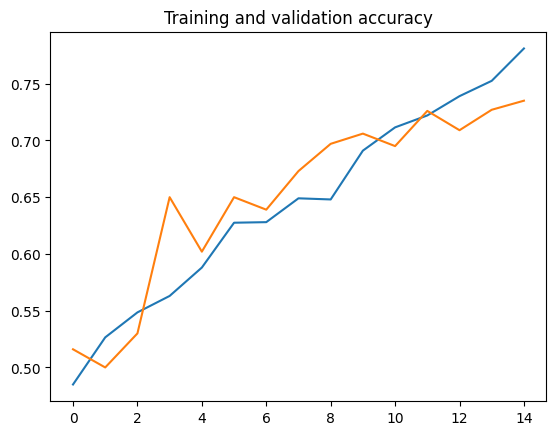

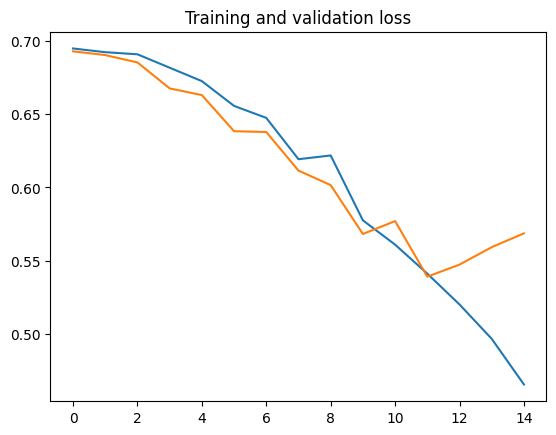

In [ ]:
# Se recuperan el error y la exactitud de los conjuntos de
# entrenamiento y validación
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(len(acc))

# Representación de la exactitud por época de los conjutos de
# entrenamiento y validación plt.plot(epochs, acc)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Representación del error por época de los conjutos de
# entrenamiento y validación
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
Y_pred = model.predict(validation_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step


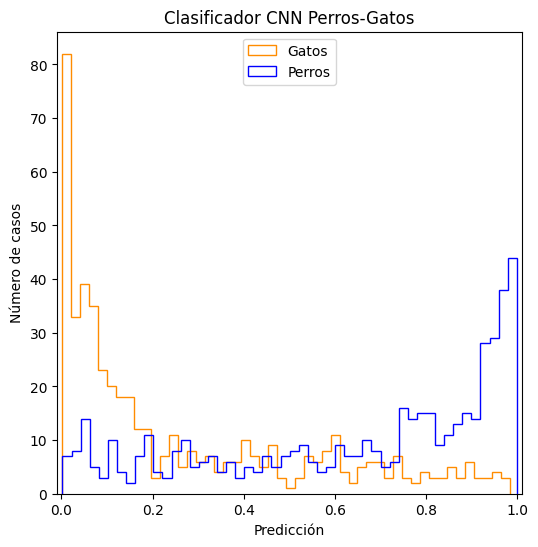

In [ ]:
# Visualización de los pronósticos.
plt.figure(1,figsize=(6,6))
#plt.style.use('seaborn-deep')
plt.hist(Y_pred[:500],50,histtype='step',color='darkorange', label= "Gatos")
plt.hist(Y_pred[500:],50,histtype='step',color='blue', label= "Perros")
plt.ylabel('Número de casos')
plt.xlabel('Predicción')
plt.title("Clasificador CNN Perros-Gatos")
plt.xlim(-0.01,1.01)
plt.legend( loc='upper center')

#from google.colab import files
#plt.savefig('ClasificadorCNNPerrosGatos.eps')
#files.download('ClasificadorCNNPerrosGatos.eps') # Descomentar para descargar localmente

### Matrix de confusión
La matrix de confusión es un sistema para evaluar la calidad de la predicción en resultados categóricos.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Se generan las etiquetas de las imágenes del conjunto de validación. Primero los valores numéricos del pronósitico, el cual es separado en dos vectores iguales. La primera mitad corresponde a los gatos y la segunda mitad a los perros. Finalmente se transforma los valores numéricos en el rango de 0 a 1, en etiquetas 0 ó 1, en función si es menor o mayor de 0.5. Este umbral es completamente arbitrario.

In [ ]:
Y_pred_cats=Y_pred[:500]
Y_pred_dogs=Y_pred[500:]

In [ ]:
Y_pred[Y_pred<=0.5] = 0
Y_pred[Y_pred>0.5] = 1

Se construye el vector que corresponde con las etiquetas originales del conjunto de validación

In [ ]:
Y_label_ori= np.zeros(len(Y_pred))
Y_label_ori[500:]=1

In [ ]:
cm=confusion_matrix(Y_label_ori, Y_pred)
print(cm)

[[390 110]
 [155 345]]


In [ ]:
# Trues
TP = cm[1,1]; print(TP)
TN = cm[0,0]; print(TN)
# Falses
FP = cm[0,1]; print(FP)
FN = cm[1,0]; print(FN)

345
390
110
155


In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity or true positive rate',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print('Specificity or true negative rate',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('Precision or positive predictive value',np.round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print('Negative predictive value',np.round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive rate',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate',FPR)
# False discovery rate
FDR = FP/(TP+FP)
print('False discovery rate',FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy',ACC)

Sensitivity or true positive rate 0.69
Specificity or true negative rate 0.78
Precision or positive predictive value 0.758
Negative predictive value 0.716
False positive rate 0.22
False negative rate 0.22
False discovery rate 0.24175824175824176
Accuracy 0.735


## Information of Spatial Attention layer

In [ ]:
# Obtener los pesos de la capa de atención
attention_weights = model.get_layer('spatial_attention').get_weights()[0]

In [ ]:
print(attention_weights.shape)
print(attention_weights)

(1, 1, 3, 1)
[[[[0.01915443]
   [0.07171377]
   [0.08858637]]]]


In [ ]:
# Crear un modelo parcial para obtener la salida de la capa de atención
attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('spatial_attention').output)

In [ ]:
image_list = []
image_labels = []

for images,labels in next(zip(train_generator)):
  image_labels_pred = model.predict(images)
  for i in range(batchsize): # can't be greater than batch size
    image_list.append(images[i])
    image_labels.append(labels[i])
    print(labels[i],image_labels_pred[i])

image_list = np.array(image_list)

print(type(image_list),image_list.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1.0 [0.90673256]
1.0 [0.91827816]
1.0 [0.23988052]
0.0 [0.04114928]
1.0 [0.43331268]
1.0 [0.97822887]
0.0 [0.01653355]
1.0 [0.8224253]
0.0 [0.1185417]
1.0 [0.8585667]
1.0 [0.46879226]
1.0 [0.8438588]
1.0 [0.7420038]
1.0 [0.9556918]
0.0 [0.18986072]
1.0 [0.9147099]
0.0 [0.48587057]
0.0 [0.17645127]
1.0 [0.8778349]
1.0 [0.9775719]
1.0 [0.7913748]
0.0 [0.00609777]
1.0 [0.42553383]
1.0 [0.7090637]
1.0 [0.95840365]
1.0 [0.60858274]
0.0 [0.01787711]
1.0 [0.9751551]
1.0 [0.72605175]
0.0 [0.00318029]
0.0 [0.03187841]
1.0 [0.4747043]
0.0 [0.5267111]
1.0 [0.09762393]
0.0 [0.40054816]
1.0 [0.92996377]
0.0 [0.01014578]
1.0 [0.8713813]
0.0 [0.01206132]
0.0 [0.05174659]
1.0 [0.17126264]
0.0 [0.03927842]
1.0 [0.28287488]
1.0 [0.4563375]
1.0 [0.98090357]
1.0 [0.34942743]
1.0 [0.8310451]
0.0 [0.09598946]
0.0 [0.3093922]
1.0 [0.9114553]
1.0 [0.9445871]
1.0 [0.2844606]
1.0 [0.01700173]
1.0 [0.090323]
0.0 [0.20443867]
1.0 [0.7444646]
0.0 [0.20124647]
0.0 [0.08580544]


In [ ]:
# Obtener la máscara de atención para la imagen de prueba
attention_map = attention_model.predict(image_list)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
print(attention_map.shape)

(64, 150, 150, 3)


In [ ]:
attention_map_mean = np.mean(attention_map, axis=-1)
print(attention_map_mean.shape)
print(np.min(attention_map_mean),np.max(attention_map_mean))

(64, 150, 150)
0.0 0.54474366


In [ ]:
attention_map_mean = np.where(attention_map_mean<0.30,0,attention_map_mean)

Original label 1.0 dog , Predicted as:  [0.43331268] cat


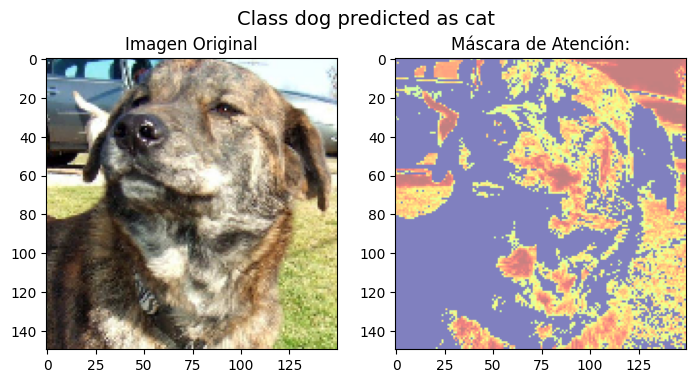

In [ ]:
idx = 4
labeltext=['cat','dog']

print('Original label', image_labels[idx], labeltext[int(image_labels[idx])],
      ', Predicted as: ', str(image_labels_pred[idx]),
      labeltext[np.squeeze(np.where(image_labels_pred[idx] > 0.5, 1, 0))]
      )

# Mostrar la imagen original y la máscara de atención
fig, ax = plt.subplots(1, 2, figsize=(8,4))

fig.text(0.5, 0.96, "Class " + str(labeltext[int(image_labels[idx])]) + ' predicted as ' + labeltext[np.squeeze(np.where(image_labels_pred[idx] > 0.5, 1, 0))],
         ha='center', va='top', fontsize=14)

# Original
ax[0].imshow(image_list[idx])
ax[0].set_title("Imagen Original")
#ax[0].set_title("Imagen Original: "+str(labeltext[int(image_labels[idx])]), ', predicted as:',labeltext[np.squeeze(np.where(image_labels_pred[idx] > 0.5, 1, 0))])

# attention map
ax[1].imshow(attention_map_mean[idx], cmap='jet', alpha=0.5)
ax[1].set_title("Máscara de Atención:")

# Adjust the layout to reduce white space between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.2)


#plt.savefig('CNN_classification_CatsDogs_SpaAtt_'+str(idx)+'.jpg')